# Download data at https://drive.google.com/drive/folders/1yfH-t6juCpK2fZg78HjmVXzl-qbtj3LI?usp=sharing

# Read the data

In [53]:
import pyreadr
import geopandas as gpd
import numpy as np

In [62]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
group_1c = (strata == 1)
group_ge2c = (strata == 2)
group_0c = (strata > 2)

In [5]:
count_1c = np.sum(group_1c.astype(int))
print(count_1c)
count_ge2c = np.sum(group_ge2c.astype(int))
print(count_ge2c)
count_0c = np.sum(group_0c.astype(int))
print(count_0c)
print(count_1c+count_ge2c+count_0c)
print(strata.shape)

2599
2599
46780
51978
(51978,)


In [5]:
bands = ['blue', 'green', 'nir', 'red', 'swir1', 'swir2', 'thermal']
merged_agg_data_1c = np.full((count_1c*7,156), np.nan, dtype=np.double) 
merged_agg_data_ge2c = np.full((count_ge2c*7,156), np.nan, dtype=np.double) 
merged_agg_data_0c = np.full((count_0c*7,156), np.nan, dtype=np.double) 
merged_ARCO_data_1c = np.empty((count_1c*7,156), dtype=np.double) 
merged_ARCO_data_ge2c = np.empty((count_ge2c*7,156), dtype=np.double) 
merged_ARCO_data_0c = np.empty((count_0c*7,156), dtype=np.double) 

data = pyreadr.read_r('clear.rds')[None].to_numpy()
clear_1c = data[group_1c]
clear_ge2c = data[group_ge2c]
clear_0c = data[group_0c]
mask_1c = (clear_1c == 250)
mask_ge2c = (clear_ge2c == 250)
mask_0c = (clear_0c == 250)
np.save('clear_1c', clear_1c)
np.save('clear_ge2c', clear_ge2c)
np.save('clear_0c', clear_0c)


for i, band in enumerate(bands):
    data = pyreadr.read_r(f'{band}.rds')[None].to_numpy()
    data_1c = data[group_1c]
    data_ge2c = data[group_ge2c]
    data_0c = data[group_0c]
    
    merged_agg_data_1c[i*count_1c:(i+1)*count_1c,:][mask_1c] = data_1c[mask_1c]
    merged_agg_data_ge2c[i*count_ge2c:(i+1)*count_ge2c,:][mask_ge2c] = data_ge2c[mask_ge2c]
    merged_agg_data_0c[i*count_0c:(i+1)*count_0c,:][mask_0c] = data_0c[mask_0c]
    
    merged_ARCO_data_1c[i*count_1c:(i+1)*count_1c,:] = data_1c
    merged_ARCO_data_ge2c[i*count_ge2c:(i+1)*count_ge2c,:] = data_ge2c
    merged_ARCO_data_0c[i*count_0c:(i+1)*count_0c,:] = data_0c
    
np.save('merged_agg_data_1c', merged_agg_data_1c)
np.save('merged_agg_data_ge2c', merged_agg_data_ge2c)
np.save('merged_agg_data_0c', merged_agg_data_0c)
np.save('merged_ARCO_data_1c', merged_ARCO_data_1c)
np.save('merged_ARCO_data_ge2c', merged_ARCO_data_ge2c)
np.save('merged_ARCO_data_0c', merged_ARCO_data_0c)


In [ ]:
data = pyreadr.read_r('clear.rds')[None].to_numpy()
clear_1c = data[group_1c]
clear_ge2c = data[group_ge2c]
clear_0c = data[group_0c]
mask_1c = (clear_1c == 250)
mask_ge2c = (clear_ge2c == 250)
mask_0c = (clear_0c == 250)

red_1c = np.full((count_1c,156), np.nan, dtype=np.double) 
red_ge2c = np.full((count_ge2c,156), np.nan, dtype=np.double) 
red_stable = np.full((count_0c,156), np.nan, dtype=np.double) 
nir_1c = np.full((count_1c,156), np.nan, dtype=np.double) 
nir_ge2c = np.full((count_ge2c,156), np.nan, dtype=np.double) 
nir_stable = np.full((count_0c,156), np.nan, dtype=np.double) 

data = pyreadr.read_r('nir.rds')[None].to_numpy()
nir_1c[mask_1c] = data[group_1c][mask_1c]
nir_ge2c[mask_ge2c] = data[group_ge2c][mask_ge2c]
nir_stable[mask_0c] = data[group_0c][mask_0c]
nir_unstable = np.concatenate((nir_1c, nir_ge2c), axis=0)

data = pyreadr.read_r('red.rds')[None].to_numpy()
red_1c[mask_1c] = data[group_1c][mask_1c]
red_ge2c[mask_ge2c] = data[group_ge2c][mask_ge2c]
red_stable[mask_0c] = data[group_0c][mask_0c]
red_unstable = np.concatenate((red_1c, red_ge2c), axis=0)

ndvi_stable = (nir_stable - red_stable) / (nir_stable + red_stable)
ndvi_unstable = (nir_unstable - red_unstable) / (nir_unstable + red_unstable)

np.save('ndvi_stable', ndvi_stable)
np.save('ndvi_unstable', ndvi_unstable)




# Compare performance of time series reconstruction methods

In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs

In [2]:
def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

In [4]:
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

In [3]:
def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.abs(np.mean(np.array(data_ref[mask_cmp], dtype=np.double)))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

In [5]:
merged_agg_data_1c = np.load('merged_agg_data_1c.npy')
merged_agg_data_ge2c = np.load('merged_agg_data_ge2c.npy')
merged_agg_data_0c = np.load('merged_agg_data_0c.npy')
ndvi_stable = np.load('ndvi_stable.npy')
ndvi_unstable = np.load('ndvi_unstable.npy')

In [ ]:
for i in range(int(data_tmp.shape[0]/7),int(data_tmp.shape[0]/7)*2,156):
    print(i)
    plt.imshow(diff[i:i+156,:])
    plt.colorbar()
    plt.show()

In [6]:
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_methods = 4
n_bands = 7
CVRMSE_mat = np.zeros((len(nan_fraction_vec), n_methods, 2, n_bands), np.double)
tot_nan_fracs = np.zeros((len(nan_fraction_vec), 2, n_bands), np.double)

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
use_NDVI = False

for k in range(n_bands): 
    for j, n_lcc in enumerate((0,1,)):
        if n_lcc == 0:
            if use_NDVI:
                data_tmp = ndvi_stable
            else:
                data_tmp = merged_agg_data_0c
        elif n_lcc == 1:
            if use_NDVI:
                data_tmp = ndvi_unstable
            else:
                data_tmp = np.concatenate((merged_agg_data_1c, merged_agg_data_ge2c), axis=0)
        n_t_tot = data_tmp.shape[0]
        n_t = int(n_t_tot/n_bands)
        assert n_t_tot%n_bands == 0, "Number samples not multiple of number of badns"
        n_s = data_tmp.shape[1]
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp[k*n_t:(k+1)*n_t,:].copy()
        for i, nan_fraction in enumerate(nan_fraction_vec):
            data = add_nan_elements(data_ref, nan_fraction)
            tot_nan_fracs[i,j,k] = np.sum(np.isnan(data).astype(int))/data.size

            wv_f_LI = 1-np.arange(1,n_s)/n_s
            wv_p_LI = wv_f_LI.copy()[::-1]
            sircleTransformer_LI = process.SircleTransformer(wv_0=1, wv_f=wv_f_LI, wv_p=wv_p_LI, backend="dense", use_mask=True, return_den=True)
            out_LI, mask_LI = sircleTransformer_LI._run(data)
            
            wv_p_MR = get_SWAG_weights(130, 0, 6, n_s)[1:][::-1]
            wv_f_MR = get_SWAG_weights(130, 0, 6, n_s)[1:]*use_future
            sircleTransformer_MR = process.SircleTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
            out_MR, mask_MR = sircleTransformer_MR._run(data)
            
            wv_0_SG = coef[w_l]
            wv_f_SG = coef[w_l+1:]
            wv_p_SG = coef[0:w_l]
            sircleTransformer_SG = process.SircleTransformer(wv_0=wv_0_SG, wv_f=wv_f_SG, wv_p=wv_p_SG, backend="sparse", use_mask=False)
            out_SG = sircleTransformer_SG._run(out_MR)

            wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
            wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*use_future
            sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
            out_prod, mask_prod = sircleTransformer_prod._run(data)
            
            wv_0_SG2 = coef[w_l]
            wv_f_SG2 = coef[w_l+1:]
            wv_p_SG2 = coef[0:w_l]
            sircleTransformer_SG2 = process.SircleTransformer(wv_0=wv_0_SG2, wv_f=wv_f_SG2, wv_p=wv_p_SG2, backend="sparse", use_mask=False)
            out_SG2 = sircleTransformer_SG2._run(out_prod)

            out_vec = (out_LI, out_SG, out_SG2, out_prod)

            CVRMSE_mat[i,:,j,k] = compute_CVRMSE(out_vec, data, data_ref)

CVRMSE_mean = np.mean(CVRMSE_mat, -1)
CVRMSE_std = np.std(CVRMSE_mat, -1)

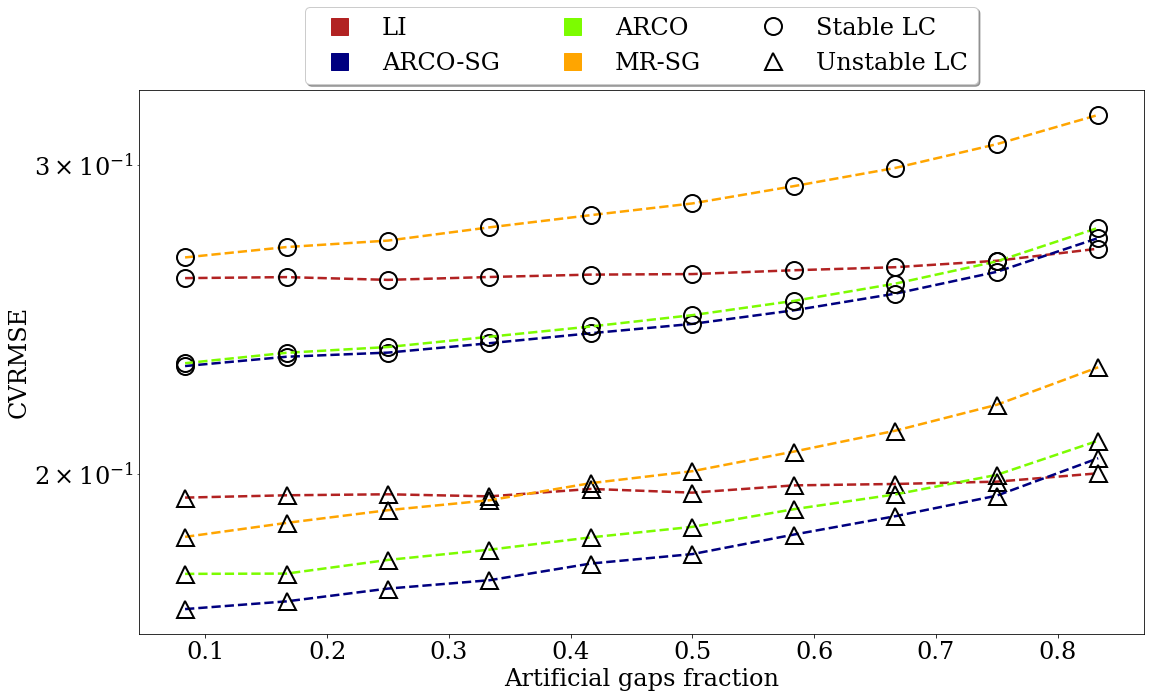

In [10]:
import matplotlib.lines as mlines
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18,10))

ms = 17
lw = 2.5
mw = 2
LI = mlines.Line2D([], [], color='firebrick', marker='s', linestyle='None',
                          markersize=ms, label='LI')
SWAG_SG = mlines.Line2D([], [], color='navy', marker='s', linestyle='None',
                          markersize=ms, label='ARCO-SG')
ARCO = mlines.Line2D([], [], color='lawngreen', marker='s', linestyle='None',
                          markersize=ms, label='ARCO')
LI_SG = mlines.Line2D([], [], color='orange', marker='s', linestyle='None',
                          markersize=ms, label='MR-SG')

stab = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markeredgewidth=mw, 
                          markersize=ms,  mfc='none', label='Stable LC')
unstab = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markeredgewidth=mw, 
                          markersize=ms,  mfc='none', label='LC change')


plt.semilogy(nan_fraction_vec, CVRMSE_mean[:,0,0], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'firebrick')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,1,0], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'orange')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,2,0], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'navy')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,3,0], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'lawngreen')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,0,1], '^', mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'firebrick')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,1,1], '^', mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'orange')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,2,1], '^', mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'navy')
plt.plot(nan_fraction_vec, CVRMSE_mean[:,3,1], '^', mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'lawngreen')
plt.legend(handles=[LI, SWAG_SG, ARCO, LI_SG, stab, unstab], loc='upper center', bbox_to_anchor=(0.5, 1.175),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Artificial gaps fraction')
plt.ylabel('CVRMSE')
plt.savefig('CVRMSE_ts_rec.png', dpi=600)
plt.show()

In [48]:
data_stable = merged_agg_data_0c
data_unstable = np.concatenate((merged_agg_data_1c, merged_agg_data_ge2c), axis=0)
gap_frac_stable = np.sum(np.isnan(data_stable).astype(int))/data_stable.size
gap_frac_unstable = np.sum(np.isnan(data_unstable).astype(int))/data_unstable.size
print(f'Fraction stable {gap_frac_stable}')
print(f'Fraction unstable {gap_frac_unstable}')

Fraction stable 0.3893132572856814
Fraction unstable 0.3101634962446813


In [ ]:
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR 1', 'SWIR 2', 'Thermal']
ymin = 0.01
ymax = 1
for k in range(n_bands):
    band = bands[k]
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(18,10))

    ms = 17
    lw = 2.5
    mw = 2
    LI = mlines.Line2D([], [], color='firebrick', marker='s', linestyle='None',
                              markersize=ms, label='LI')
    SWAG_SG = mlines.Line2D([], [], color='navy', marker='s', linestyle='None',
                              markersize=ms, label='ARCO-SG')
    ARCO = mlines.Line2D([], [], color='lawngreen', marker='s', linestyle='None',
                              markersize=ms, label='ARCO')
    LI_SG = mlines.Line2D([], [], color='orange', marker='s', linestyle='None',
                              markersize=ms, label='MR-SG')

    stab = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markeredgewidth=mw, 
                              markersize=ms,  mfc='none', label='Stable LC')
    unstab = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markeredgewidth=mw, 
                              markersize=ms,  mfc='none', label='LC change')

    CVRMSE_mat[i,:,j,k]

    plt.plot(tot_nan_fracs[:,0,k], CVRMSE_mat[:,0,0,k], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'firebrick')
    plt.plot(tot_nan_fracs[:,0,k], CVRMSE_mat[:,1,0,k], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'orange')
    plt.plot(tot_nan_fracs[:,0,k], CVRMSE_mat[:,2,0,k], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'navy')
    plt.plot(tot_nan_fracs[:,0,k], CVRMSE_mat[:,3,0,k], 'o',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'lawngreen')
    plt.plot(tot_nan_fracs[:,1,k], CVRMSE_mat[:,0,1,k], '^', mfc='none', mec='k', markersize=ms, linestyle='-', linewidth=lw, markeredgewidth=mw, color = 'firebrick')
    plt.plot(tot_nan_fracs[:,1,k], CVRMSE_mat[:,1,1,k], '^', mfc='none', mec='k', markersize=ms, linestyle='-', linewidth=lw, markeredgewidth=mw, color = 'orange')
    plt.plot(tot_nan_fracs[:,1,k], CVRMSE_mat[:,2,1,k], '^', mfc='none', mec='k', markersize=ms, linestyle='-', linewidth=lw, markeredgewidth=mw, color = 'navy')
    plt.plot(tot_nan_fracs[:,1,k], CVRMSE_mat[:,3,1,k], '^', mfc='none', mec='k', markersize=ms, linestyle='-', linewidth=lw, markeredgewidth=mw, color = 'lawngreen')
    plt.vlines(gap_frac_stable, np.min(CVRMSE_mat[:,:,:,k]), np.max(CVRMSE_mat[:,:,:,k]), colors='k', linestyles='--')
    plt.vlines(gap_frac_unstable, np.min(CVRMSE_mat[:,:,:,k]), np.max(CVRMSE_mat[:,:,:,k]), colors='k', linestyles='-')
    # plt.legend(handles=[LI, SWAG_SG, ARCO, LI_SG, stab, unstab], loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=3, fancybox=True, shadow=True)
    plt.xlabel('Total gaps fraction')
    plt.ylabel('CVRMSE')
    plt.title(band)
    # plt.savefig(f'CVRMSE_ts_rec_{band}.png', dpi=600)
    plt.show()


In [ ]:
n_bands = 7
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR 1', 'SWIR 2', 'Thermal']
for k in range(n_bands):
    band = bands[k]
    for j, n_lcc in enumerate((1,)):
        if n_lcc == 0:
            data_tmp = merged_agg_data_0c
        elif n_lcc == 1:           
            data_tmp = np.concatenate((merged_agg_data_1c, merged_agg_data_ge2c), axis=0)
        n_t_tot = data_tmp.shape[0]
        n_t = int(n_t_tot/n_bands)
        assert n_t_tot%n_bands == 0, "Number samples not multiple of number of badns"
        n_s = data_tmp.shape[1]
        data_band = data_tmp[k*n_t:(k+1)*n_t,:].copy()
        plt.hist(data_band[~np.isnan(data_band)], bins=np.linspace(0,250,250))
        plt.ylim(ymax=30000)
        plt.title(f"{band} LCC {n_lcc}")
        plt.show() 

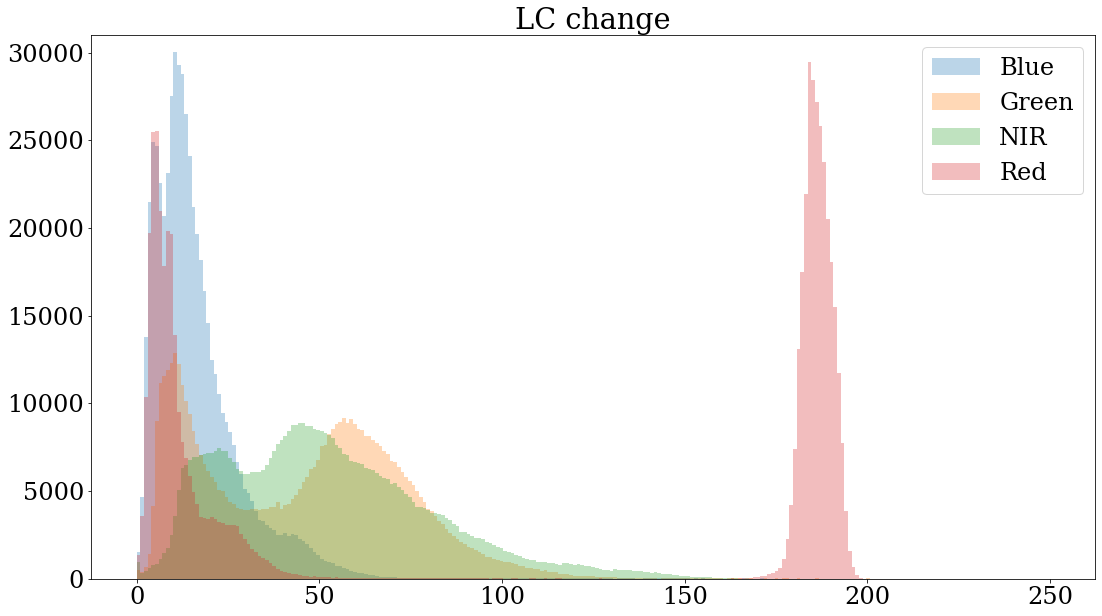

In [45]:
n_bands = 7
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR 1', 'SWIR 2', 'Thermal']

plt.figure(figsize=(18,10))
for k in range(4):
    band = bands[k]
    for j, n_lcc in enumerate((1,)):
        if n_lcc == 0:
            data_tmp = merged_agg_data_0c
        elif n_lcc == 1:           
            data_tmp = np.concatenate((merged_agg_data_1c, merged_agg_data_ge2c), axis=0)
        n_t_tot = data_tmp.shape[0]
        n_t = int(n_t_tot/n_bands)
        assert n_t_tot%n_bands == 0, "Number samples not multiple of number of badns"
        n_s = data_tmp.shape[1]
        data_band = data_tmp[k*n_t:(k+1)*n_t,:].copy()
        plt.hist(data_band[~np.isnan(data_band)], bins=np.linspace(0,250,250), label=f"{band}", histtype='stepfilled', alpha=0.3)
        plt.ylim(ymax=31000)
plt.title(f"LC change")
plt.legend()
plt.show() 

In [ ]:
import importlib
importlib.reload(process)

att_env = 60
att_seas = 60
rec_win_size = 12
use_future = 0
w_l = 1
p_o = 1
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
use_NDVI = False
n_lcc = 1
if n_lcc == 0:
    data_tmp = merged_agg_data_0c
elif n_lcc == 1:
    data_tmp = np.concatenate((merged_agg_data_1c, merged_agg_data_ge2c), axis=0)
n_t = data_tmp.shape[0]
n_s = data_tmp.shape[1]

data_ref = np.zeros((1, n_t, n_s))
data_ref[0,:,:] = data_tmp.copy()
nan_fraction = 0.1
data = add_nan_elements(data_ref, nan_fraction)

wv_p_MR = np.full((n_s,), pow(10.0,-12.0), dtype=np.double)
wv_p_MR[-(rec_win_size-2):] = np.power(10.0, -np.arange(2,rec_win_size))[::-1]
wv_f_MR = np.power(10.0, -np.arange(2,rec_win_size))*use_future
sircleTransformer_MR = process.SircleTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
out_MR, QA_MR = sircleTransformer_MR._run(data)

# mask_cmp = np.isnan(data) & ~np.isnan(data_ref) & ~np.isnan(out_MR) & (data_ref!=0)
# elem_rerr = np.abs(np.array(data_ref[mask_cmp] - out_MR[mask_cmp])) / np.abs(data_ref[mask_cmp])
# elem_QA = QA_MR[mask_cmp]


In [ ]:
plt.scatter(elem_rerr,elem_QA)
plt.show()

In [14]:
merged_ARCO_data_1c = np.load('merged_ARCO_data_1c.npy')
data_tmp = merged_agg_data_1c.copy()
n_t = data_tmp.shape[0]
n_s = data_tmp.shape[1]
data = np.zeros((1, n_t, n_s))
data[0,:,:] = data_tmp.copy()
wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*0.0
sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="FFT", use_mask=True)
out_prod = sircleTransformer_prod._run(data)

In [15]:
print(np.sum(np.isnan(merged_ARCO_data_1c).astype(int)))

54658


In [16]:
print(np.sum(np.isnan(out_prod).astype(int)))

54537


In [17]:
out_ARCO = np.round(out_prod[0,:,:])
diff = merged_ARCO_data_1c-out_ARCO
diff[np.isnan(out_ARCO)] = 0
diff[np.isnan(merged_ARCO_data_1c)] = 0
diff_p = diff[diff!=0.]
print(np.max(diff_p))
print(np.min(diff_p))

191.0
-5.0


# Stratified comparison

In [1]:
import pyreadr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs

In [2]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
u_strata = np.unique(strata)

In [4]:
def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

In [17]:
def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.mean(np.array(data_ref[mask_cmp], dtype=np.double))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

In [18]:
def compute_NRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        std_ref = np.std(np.array(data_ref[mask_cmp], dtype=np.double))
        CVRMSE = RMSE / std_ref
        rerr.append(CVRMSE)
    return rerr

In [6]:
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

In [ ]:
bands = ['blue', 'green', 'nir', 'red', 'swir1', 'swir2', 'thermal']

n_strata = len(u_strata)

CVRMSE_mat = np.zeros((7,n_strata))
NRMSE_mat = np.zeros((7,n_strata))
tot_nan_fracs = np.zeros((n_strata,))

nan_fraction = 0.1
cleat_mat = pyreadr.read_r('clear.rds')[None].to_numpy()
for i, band in enumerate(bands):
    band_mat = pyreadr.read_r(f'{band}.rds')[None].to_numpy()
    print(f"Band {band}")
    print(f"Stratum: ", end="")
    for j, stratum in enumerate(u_strata):
        print(f"{stratum}, ", end="")
        agg_nogap_mask = (cleat_mat[strata==stratum,:] == 250)    
        data_tmp = band_mat[strata==stratum,:]
        data_tmp[~agg_nogap_mask] = np.nan
        n_t = data_tmp.shape[
        0]n_s = data_tmp.shape[1]
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()
        data = add_nan_elements(data_ref, nan_fraction)
        tot_nan_fracs[j] = np.sum(np.isnan(data).astype(int))/data.size

        wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*0.0
        sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True)
        out_prod = sircleTransformer_prod._run(data)
        
        CVRMSE_mat[i,j] = compute_CVRMSE((out_prod,), data, data_ref)[0]
        NRMSE_mat[i,j] = compute_NRMSE((out_prod,), data, data_ref)[0]
    print(f" ")

    
    


Band blue
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band green
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band nir
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band red
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir1
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir2
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band thermal
Stratum: 1, 2, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  


## Legend of ESA-CCI at https://maps.elie.ucl.ac.be/CCI/viewer/download/CCI-LC_Maps_Legend.pdf

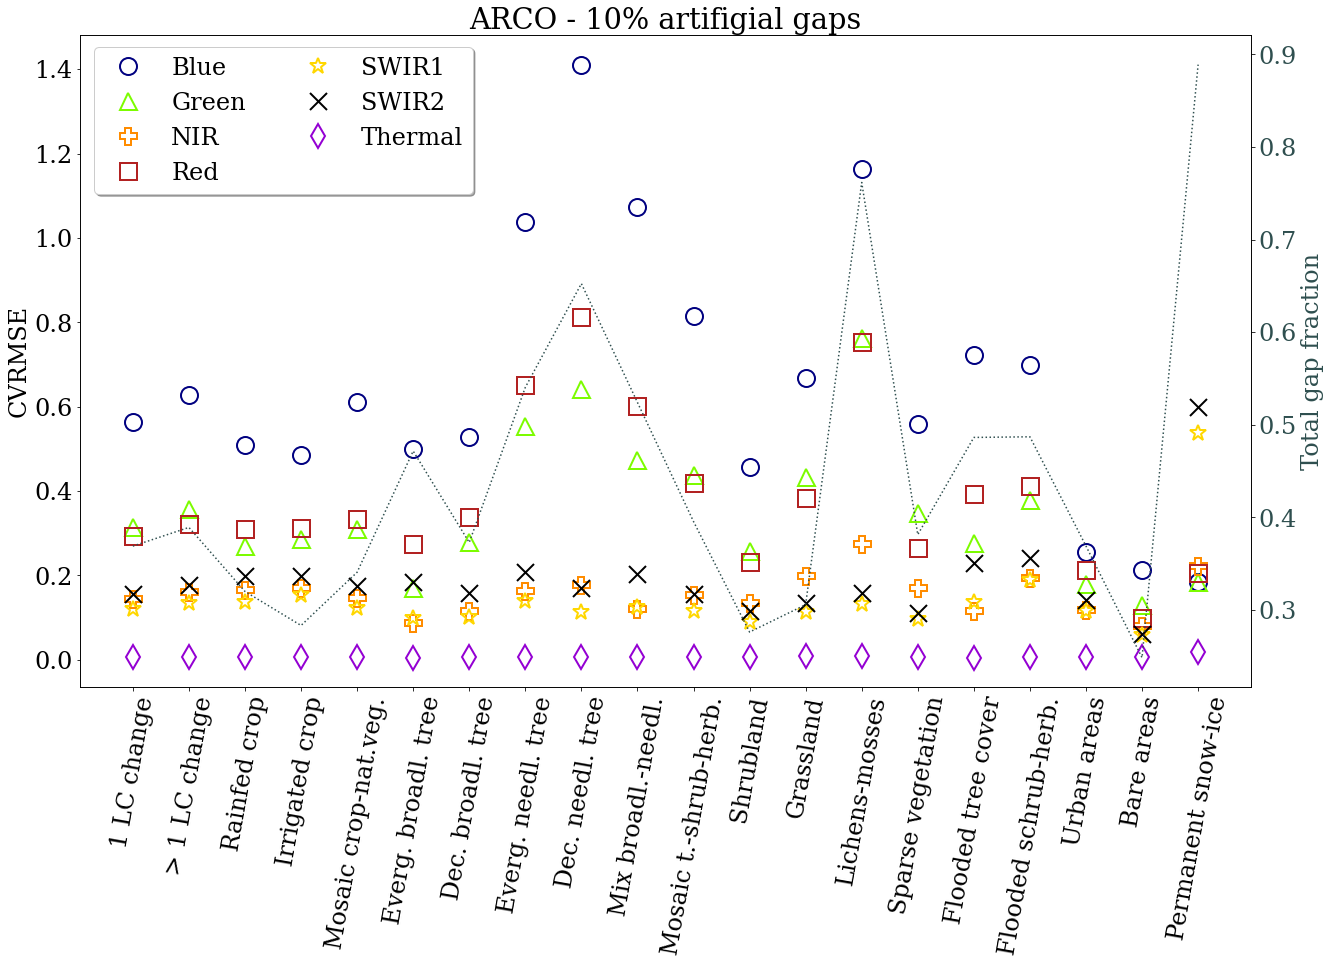

In [108]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 24})
fig, ax1 = plt.subplots(figsize=(21,12))

ms = 17
mw = 2
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR1', 'SWIR2', 'Thermal']
marker_list = ['o', '^', 'P', 's', '*', 'x', 'd']
color_list = ['navy', 'lawngreen', 'darkorange', 'firebrick', 'gold', 'black', 'darkviolet']
# ticks = ['1','2','10','20','30','50','60','70','80','90','100','120','130','140','150','160','180','190','200','220']
ticks = ['1 LC change','> 1 LC change','Rainfed crop','Irrigated crop','Mosaic crop-nat.veg.','Everg. broadl. tree','Dec. broadl. tree','Everg. needl. tree','Dec. needl. tree', \
         'Mix broadl.-needl.','Mosaic t.-shrub-herb.','Shrubland','Grassland','Lichens-mosses','Sparse vegetation','Flooded tree cover','Flooded schrub-herb.','Urban areas','Bare areas','Permanent snow-ice']
handles = []
for i, band in enumerate(bands):
    handles.append(mlines.Line2D([], [], color=color_list[i], marker=marker_list[i], linestyle='None', markeredgewidth=mw, 
                          markersize=ms,  mfc='none', label=bands[i]))
    for j, stratum in enumerate(u_strata):
        ax1.plot(j, CVRMSE_mat[i,j], marker=marker_list[i],  markersize=ms,  mfc='none', color=color_list[i], markeredgewidth=mw)
ax1.set_ylabel('CVRMSE')       
ax1.set_xticks(range(n_strata), minor=False)
ax1.set_xticklabels(ticks, fontdict=None, minor=False, rotation=80)
ax1.set_title('ARCO - 10% artifigial gaps')
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.26, 0.88),
          ncol=2, fancybox=True, shadow=True)
ax2 = ax1.twinx()
color = 'darkslategray'
ax2.set_ylabel('Total gap fraction', color=color)
ax2.plot(range(n_strata), tot_nan_fracs, linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig('ESACCI_CVRMSE.png', dpi=600)
fig.show()